In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [2]:
# This is monthly data since 1958
# columns = ["year", "month", "decimal date", "average", "interpolated", "trend", "?"]
# co2 = pd.read_csv("ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt",
#                   delim_whitespace=True, skiprows=72, names=columns, parse_dates=[[0, 1]])

In [3]:
# this here is weekly data since 1974
# see https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html
url = "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt"
names = ["year", "month", "day", "year_decimal", "co2", "days", "1 yr ago",
          "10 yr ago", "since 1800"]
maunaloa = pd.read_csv(url, skiprows=49, header=None, delim_whitespace=True,
                       names=names, na_values=[-999.99])
maunaloa.head()

,year,month,day,year_decimal,co2,days,1 yr ago,10 yr ago,since 1800
0,1974,5,19,1974.3795,333.34,6,NaN,NaN,50.36
1,1974,5,26,1974.3986,332.95,6,NaN,NaN,50.06
2,1974,6,2,1974.4178,332.32,5,NaN,NaN,49.57
3,1974,6,9,1974.4370,332.18,7,NaN,NaN,49.63
4,1974,6,16,1974.4562,332.37,7,NaN,NaN,50.07


In [4]:
maunaloa = pd.read_csv(url, skiprows=49, header=None, delim_whitespace=True,
                       names=names, parse_dates=[[0, 1, 2]], na_values=[-999.99])
maunaloa.head()

,year_month_day,year_decimal,co2,days,1 yr ago,10 yr ago,since 1800
0,1974-05-19,1974.3795,333.34,6,NaN,NaN,50.36
1,1974-05-26,1974.3986,332.95,6,NaN,NaN,50.06
2,1974-06-02,1974.4178,332.32,5,NaN,NaN,49.57
3,1974-06-09,1974.4370,332.18,7,NaN,NaN,49.63
4,1974-06-16,1974.4562,332.37,7,NaN,NaN,50.07


In [5]:
maunaloa = pd.read_csv(url, skiprows=49, header=None, delim_whitespace=True,
                       names=names, parse_dates=[[0, 1, 2]], na_values=[-999.99],
                       index_col="year_month_day")
maunaloa.head()

,year_decimal,co2,days,1 yr ago,10 yr ago,since 1800
year_month_day,,,,,,
1974-05-19,1974.3795,333.34,6,NaN,NaN,50.36
1974-05-26,1974.3986,332.95,6,NaN,NaN,50.06
1974-06-02,1974.4178,332.32,5,NaN,NaN,49.57
1974-06-09,1974.4370,332.18,7,NaN,NaN,49.63
1974-06-16,1974.4562,332.37,7,NaN,NaN,50.07


In [6]:
maunaloa.co2.head()


year_month_day
1974-05-19    333.34
1974-05-26    332.95
1974-06-02    332.32
1974-06-09    332.18
1974-06-16    332.37
Name: co2, dtype: float64

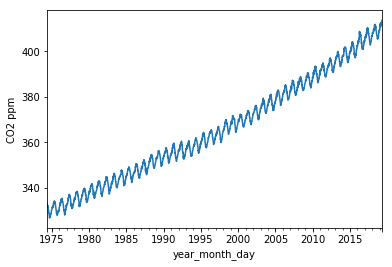

In [28]:
maunaloa.co2.plot()
plt.ylabel("CO2 ppm")
plt.savefig("images/maunaloa plot.png")

In [11]:
# set index frequency for statsmodel models
maunaloa.index = pd.DatetimeIndex(maunaloa.index, freq=maunaloa.index.inferred_freq)

# uneven time series from volcanic erruptions

In [12]:
volcano = pd.read_csv("https://www.ngdc.noaa.gov/nndc/struts/results?type_0=Exact&query_0=$HAZ_EVENT_ID&t=102557&s=50&d=54&dfn=volerup.txt",
                      delimiter="\t", parse_dates=[["Year", "Month", "Day"]])

In [13]:
volcano[-10:]

,Year_Month_Day,TSU,EQ,Name,Location,Country,Latitude,Longitude,Elevation,Type,...,TOTAL_DEATHS,TOTAL_DEATHS_DESCRIPTION,TOTAL_MISSING,TOTAL_MISSING_DESCRIPTION,TOTAL_INJURIES,TOTAL_INJURIES_DESCRIPTION,TOTAL_DAMAGE_MILLIONS_DOLLARS,TOTAL_DAMAGE_DESCRIPTION,TOTAL_HOUSES_DESTROYED,TOTAL_HOUSES_DESTROYED_DESCRIPTION
816,2018 3 21,NaN,NaN,Ijen,Java,Indonesia,-8.058,114.242,2799,Stratovolcano,...,NaN,NaN,NaN,NaN,30.0,1.0,NaN,NaN,NaN,NaN
817,2018 3 30,NaN,NaN,Aoba,Vanuatu-SW Pacific,Vanuatu,-15.400,167.830,1496,Shield volcano,...,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0
818,2018 4 28,TSU,EQ,Kilauea,Hawaiian Is,United States,19.425,-155.292,1222,Shield volcano,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,4.0,700.0,3.0
819,2018 6 3,NaN,NaN,Fuego,Guatemala,Guatemala,14.473,-90.880,3763,Stratovolcano,...,165.0,3.0,260.0,3.0,55.0,2.0,NaN,3.0,186.0,3.0
820,2018 7 16,NaN,NaN,Kilauea,Hawaiian Is,United States,19.425,-155.292,1222,Shield volcano,...,NaN,NaN,NaN,NaN,23.0,1.0,1.0,1.0,NaN,NaN
821,2018 8 25,NaN,NaN,Manam,New Guinea-NE of,Papua New Guinea,-4.100,145.061,1807,Stratovolcano,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,164.0,3.0
822,2018 12 15,NaN,EQ,Ambrym,Vanuatu-SW Pacific,Vanuatu,-16.250,168.120,1334,Pyroclastic shield,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0
823,2018 12 22,TSU,NaN,Krakatau,Indonesia,Indonesia,-6.102,105.423,813,Caldera,...,437.0,3.0,16.0,1.0,14059.0,4.0,NaN,3.0,2844.0,4.0
824,2018 12 26,NaN,EQ,Etna,Italy,Italy,37.734,15.004,3350,Stratovolcano,...,NaN,NaN,NaN,NaN,28.0,1.0,114.0,4.0,15.0,1.0
825,2019 1 7,NaN,NaN,Manam,New Guinea-NE of,Papua New Guinea,-4.100,145.061,1807,Stratovolcano,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


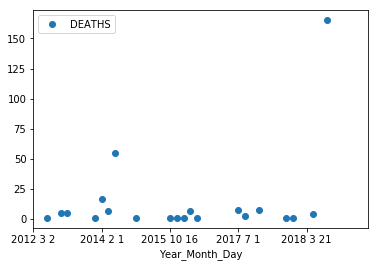

In [14]:
volcano[-50:].plot("Year_Month_Day", "DEATHS", marker="o", linestyle="none")

# Backfill and forward fill

In [16]:
maunaloa.co2.isnull().sum()


20

In [17]:
maunaloa.fillna(method="ffill", inplace=True)  # or bfill
maunaloa.co2.isnull().sum()

0

# Resampling

In [18]:
# resampling is lazy
resampled_co2 = maunaloa.co2.resample("MS")
resampled_co2

DatetimeIndexResampler [freq=<MonthBegin>, axis=0, closed=left, label=left, convention=start, base=0]

In [19]:
resampled_co2.mean().head()

year_month_day
1974-05-01    333.1450
1974-06-01    332.0280
1974-07-01    330.7125
1974-08-01    329.0725
1974-09-01    327.3240
Freq: MS, Name: co2, dtype: float64

In [25]:
maunaloa.co2.rename('W')

year_month_day
1974-05-19    333.34
1974-05-26    332.95
1974-06-02    332.32
1974-06-09    332.18
1974-06-16    332.37
1974-06-23    331.59
1974-06-30    331.68
1974-07-07    331.44
1974-07-14    330.85
1974-07-21    330.76
1974-07-28    329.80
1974-08-04    329.85
1974-08-11    329.05
1974-08-18    329.06
1974-08-25    328.33
1974-09-01    328.05
1974-09-08    327.57
1974-09-15    326.73
1974-09-22    326.96
1974-09-29    327.31
1974-10-06    327.07
1974-10-13    327.23
1974-10-20    327.40
1974-10-27    327.64
1974-11-03    327.80
1974-11-10    328.50
1974-11-17    328.56
1974-11-24    328.46
1974-12-01    328.76
1974-12-08    329.39
               ...  
2018-09-23    405.54
2018-09-30    405.50
2018-10-07    405.58
2018-10-14    406.00
2018-10-21    406.62
2018-10-28    406.48
2018-11-04    406.99
2018-11-11    408.72
2018-11-18    408.60
2018-11-25    408.38
2018-12-02    408.49
2018-12-09    409.40
2018-12-16    409.30
2018-12-23    409.13
2018-12-30    409.60
2019-01-06    410.6

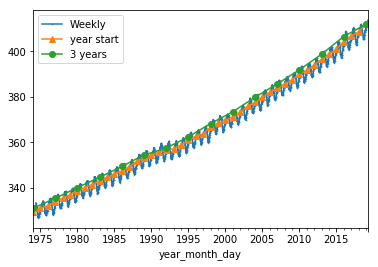

In [27]:
maunaloa.co2.resample("W").mean().rename("Weekly").plot(marker=".", markersize=1)
maunaloa.co2.resample("AS").mean().rename("year start").plot(marker="^")
maunaloa.co2.resample("3AS").mean().rename("3 years").plot(marker="o")
plt.legend()
plt.savefig("images/maunaloa resample.png")

# Autocorrelation

In [34]:
ppm = maunaloa.co2
ppm.autocorr()

0.999704774958398

In [42]:
ppm.autocorr(lag=26)

0.9826547764829218

In [43]:
ppm.autocorr(lag=52)

0.999431997884552

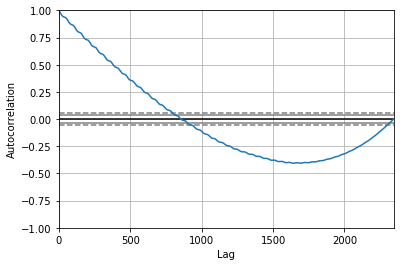

In [46]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ppm)
plt.savefig("images/autocorr.png")

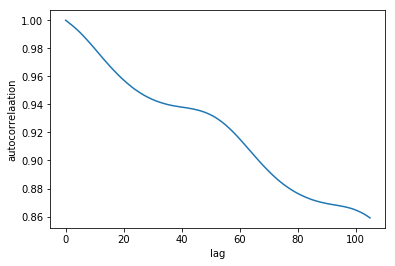

In [57]:
from statsmodels.tsa.stattools import acf
autocorrelation = acf(ppm, nlags=105)
plt.plot(autocorrelation)
plt.ylabel("autocorrelaation")
plt.xlabel("lag")
plt.savefig("images/autocorr 2.png")

# detrending

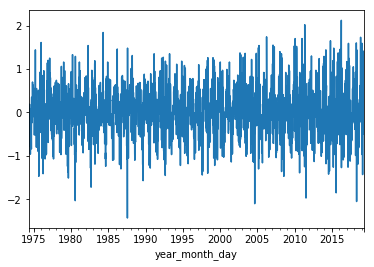

In [50]:
ppm.diff().plot()
plt.savefig("images/detrending.png")

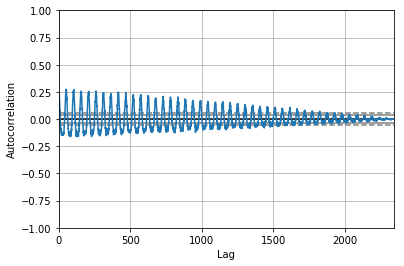

In [55]:
autocorrelation_plot(ppm.diff()[1:])
plt.savefig("images/autocorr 3.png")

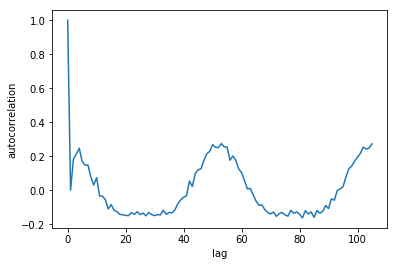

In [56]:
from statsmodels.tsa.stattools import acf
autocorrelation = acf(ppm.diff()[1:], nlags=105)
plt.plot(autocorrelation)
plt.ylabel("autocorrelation")
plt.xlabel("lag")
plt.savefig("images/autocorr 4.png")

In [18]:
aapl = pd.read_csv("https://github.com/scikit-learn/examples-data/raw/master/financial-data/AAPL.csv")

In [19]:
aapl.head()

,date,open,close
0,2003-01-02,14.36,14.80
1,2003-01-03,14.80,14.90
2,2003-01-06,15.03,14.90
3,2003-01-07,14.79,14.85
4,2003-01-08,14.58,14.55


In [20]:
aapl.set_index("date", inplace=True)
aapl.sort_index(inplace=True)

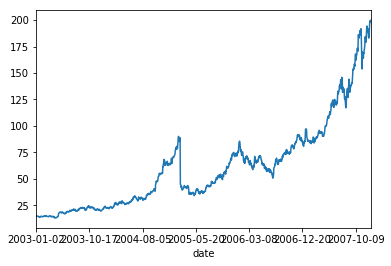

In [21]:
aapl.close.plot()

In [22]:
msft = pd.read_csv("https://github.com/scikit-learn/examples-data/raw/master/financial-data/MSFT.csv", parse_dates=["date"], index_col='date')

In [23]:
yhoo = pd.read_csv("https://github.com/scikit-learn/examples-data/raw/master/financial-data/YHOO.csv", parse_dates=["date"])

In [24]:
yhoo.set_index("date", inplace=True)
yhoo.sort_index(inplace=True)

In [25]:
combined_stock = pd.concat([yhoo.close, aapl.close, msft.close], axis=1)

In [26]:
combined_stock.columns = ['YHOO', 'AAPL', 'MSFT']

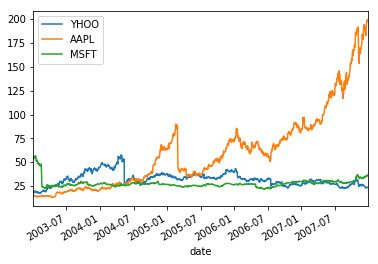

In [27]:
combined_stock.plot()

In [28]:
yhoo.close.autocorr()

0.9879423052246653

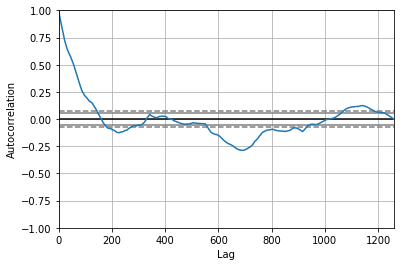

In [29]:
autocorrelation_plot(yhoo)


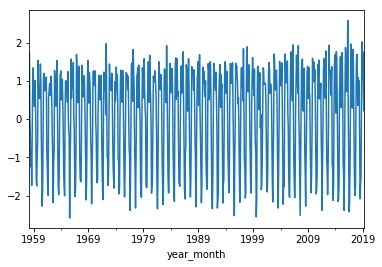

In [30]:
ppm.diff().plot()

# Seasonal model for co2

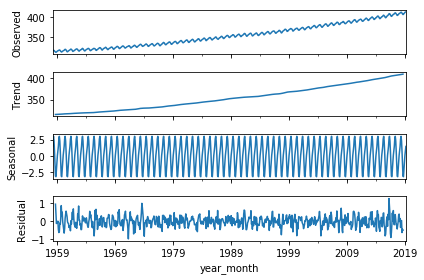

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ppm, model='additive')
fig = decomposition.plot()
#fig.set_figheight(6)
fig.tight_layout()

In [32]:
ppm.shape

(733,)

# Autoregressive models

In [33]:
from statsmodels.tsa import ar_model
ar = ar_model.AR(ppm[:500])
res = ar.fit(maxlag=12)
res.params

const              -2.017233
L1.interpolated     0.932486
L2.interpolated    -0.241287
L3.interpolated    -0.099031
L4.interpolated    -0.076112
L5.interpolated     0.164381
L6.interpolated    -0.000720
L7.interpolated    -0.023320
L8.interpolated    -0.125592
L9.interpolated     0.101533
L10.interpolated   -0.022924
L11.interpolated    0.415948
L12.interpolated   -0.017955
dtype: float64

/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


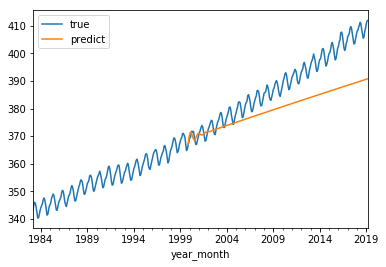

In [38]:
ppm[300:].plot(label="true")
res.predict(ppm.index[500], ppm.index[-1]).plot(label="predict")
plt.legend(loc="best")

/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


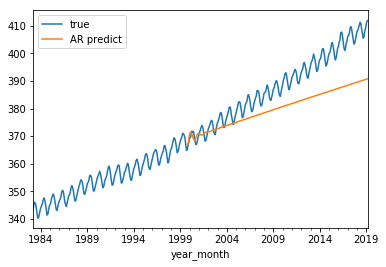

In [39]:
ar6 = ar_model.AR(ppm[:500])
res = ar6.fit(maxlag=6)
ar_pred = res.predict(ppm.index[500], ppm.index[-1])
ppm[300:].plot(label="true")
ar_pred.plot(label="AR predict")
plt.legend(loc="best")


/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


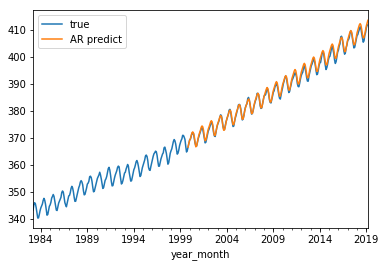

In [40]:
ar25 = ar_model.AR(ppm[:500])
res = ar25.fit(maxlag=25)
ar_pred = res.predict(ppm.index[500], ppm.index[-1])
ppm[300:].plot(label="true")
ar_pred.plot(label="AR predict")
plt.legend(loc="best")


/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


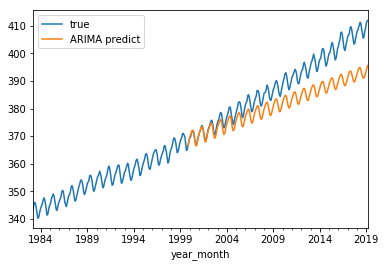

In [41]:
from statsmodels import tsa

arima_model = tsa.arima_model.ARIMA(ppm[:500], order=(12, 1, 0))
res = arima_model.fit()
arima_pred = res.predict(ppm.index[500], ppm.index[-1], typ="levels")
ppm[300:].plot(label="true")
arima_pred.plot(label="ARIMA predict")
plt.legend(loc="best")

# building our own model

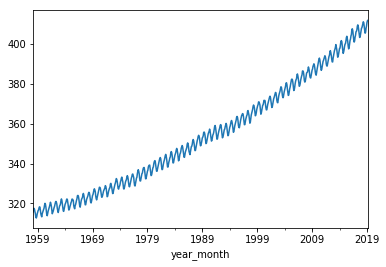

In [42]:
ppm.plot()

In [43]:
ppm.shape

(733,)

In [44]:
train = ppm[:500]
test = ppm[500:]

In [45]:
X = ppm.index.to_series().apply(lambda x: x.toordinal())
X = pd.DataFrame(X)

X_train, X_test = X.iloc[:500, :], X.iloc[500:, :]
X_train.shape

(500, 1)

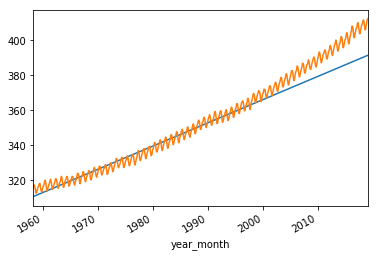

In [46]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, train)
lr_pred = lr.predict(X_test)
plt.plot(ppm.index, lr.predict(X))
ppm.plot()

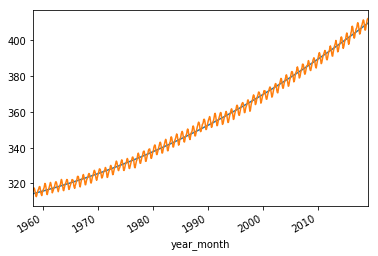

In [47]:
from sklearn.preprocessing import PolynomialFeatures
lr_poly = make_pipeline(PolynomialFeatures(include_bias=False), LinearRegression())
lr_poly.fit(X_train, train)

plt.plot(ppm.index, lr_poly.predict(X))
ppm.plot()

# cross-validation

In [48]:
X_train.head()

,year_month
year_month,
1958-03-01,714839
1958-04-01,714870
1958-05-01,714900
1958-06-01,714931
1958-07-01,714961


In [49]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
scores_iid = cross_val_score(LinearRegression(), X_train, train, cv=10,
                             scoring="neg_mean_squared_error")
np.mean(scores_iid)

-9.836276396349135

In [50]:
scores_time = cross_val_score(LinearRegression(), X_train, train, cv=TimeSeriesSplit(n_splits=10),
                              scoring="neg_mean_squared_error")
np.mean(scores_time)

-10.295927484695229

In [51]:
from sklearn.tree import DecisionTreeRegressor
scores_iid = cross_val_score(DecisionTreeRegressor(), X_train, train, cv=10,
                              scoring="neg_mean_squared_error")
np.mean(scores_iid)

-14.680895999999972

In [52]:
scores_time = cross_val_score(DecisionTreeRegressor(), X_train, train, cv=TimeSeriesSplit(n_splits=10),
                              scoring="neg_mean_squared_error")
np.mean(scores_time)

-16.47052244444443

In [53]:
from sklearn.model_selection import cross_val_predict
asdf = cross_val_predict(LinearRegression(), X_train.values, train.values, cv=10)

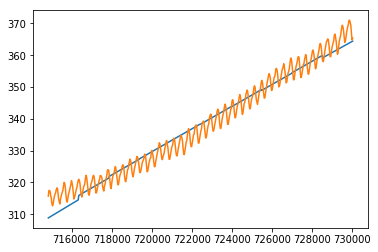

In [54]:
plt.plot(X_train, asdf)
plt.plot(X_train, train)

In [55]:
y_res = ppm - lr_poly.predict(X)

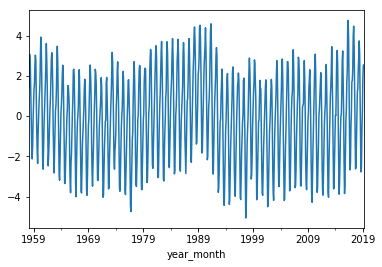

In [56]:
y_res.plot()

In [57]:
from statsmodels.tsa import arima_model
ar_model = arima_model.ARMA(ppm[:500].diff()[1:], order=(12, 0))
res = ar_model.fit()

In [58]:
ar_pred = res.predict(ppm.index[500], ppm.index[-1])
pred_arma_diff = np.cumsum(ar_pred) + ppm[500]

/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


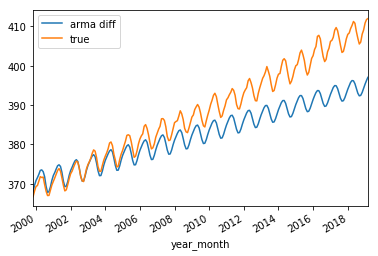

In [59]:
plt.plot(ppm.index[500:], pred_arma_diff, label="arma diff")
ppm[500:].plot(label="true")
plt.legend()

In [60]:
from statsmodels.tsa import ar_model
ar_model_res = ar_model.AR(y_res[:500])
res_res = ar_model_res.fit(maxlag=12)

ar_pred_res = res_res.predict(ppm.index[500], ppm.index[-1])
pred_ar_res = ar_pred_res + lr_poly.predict(X_test)

/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [61]:
res_res.params

const              -0.008036
L1.interpolated     0.923239
L2.interpolated    -0.243672
L3.interpolated    -0.101150
L4.interpolated    -0.077162
L5.interpolated     0.157972
L6.interpolated    -0.006332
L7.interpolated    -0.023741
L8.interpolated    -0.126833
L9.interpolated     0.093907
L10.interpolated   -0.027295
L11.interpolated    0.415392
L12.interpolated   -0.018769
dtype: float64

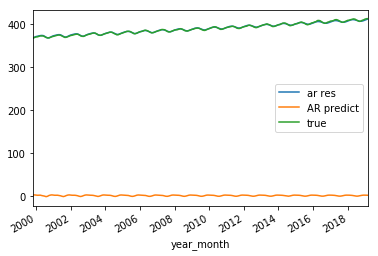

In [62]:
plt.plot(ppm.index[500:], pred_ar_res, label="ar res")
ar_pred.plot(label="AR predict")
ppm[500:].plot(label="true")

plt.legend(loc="best")

In [63]:
X_month = pd.concat([X, pd.DataFrame({'month': X.index.month}, index=X.index)], axis=1)

In [64]:
X_month.head()

,year_month,month
year_month,,
1958-03-01,714839,3
1958-04-01,714870,4
1958-05-01,714900,5
1958-06-01,714931,6
1958-07-01,714961,7


In [65]:
X_train_month = X_month[:500]
X_test_month = X_month[500:]
lr_poly_month = make_pipeline(PolynomialFeatures(include_bias=False), LinearRegression())
lr_poly_month.fit(X_train_month, train)
X_test_month.shape

(233, 2)

In [66]:
from statsmodels.tsa import ar_model
arma_model_res = arima_model.ARMA(y_res[:500], order=(12, 0))
res_arma_res = arma_model_res.fit(maxlag=12)

arma_pred_res = res_arma_res.predict(ppm.index[500], ppm.index[-1])
pred_arma_res = arma_pred_res + lr_poly.predict(X_test)

/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


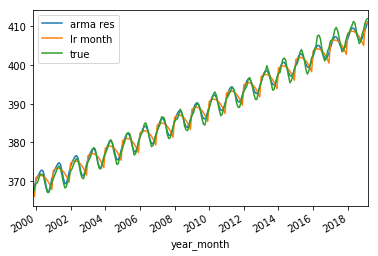

In [67]:
plt.plot(ppm.index[500:], pred_arma_res, label="arma res")
plt.plot(ppm.index[500:], lr_poly_month.predict(X_test_month), label="lr month")

ppm[500:].plot(label="true")
plt.legend(loc="best")

In [68]:
from sklearn.preprocessing import OneHotEncoder
lr_poly_month_ohe = make_pipeline(OneHotEncoder(categorical_features=[1], sparse=False),
                                  PolynomialFeatures(include_bias=False), LinearRegression())
lr_poly_month_ohe.fit(X_train_month, train)

/home/andy/checkout/scikit-learn/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/andy/checkout/scikit-learn/sklearn/preprocessing/_encoders.py:450: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(categorical_features=[1], categories=None,
                               drop=None, dtype=<class 'numpy.float64'>,
                               handle_unknown='error', n_values=None,
                               sparse=False)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))])

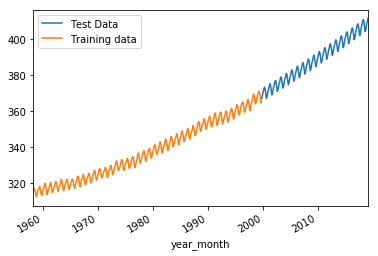

In [69]:
plt.plot(ppm.index[500:], lr_poly_month_ohe.predict(X_test_month), label="lr month")
ppm[:500].plot()
plt.legend(["Test Data", "Training data"])

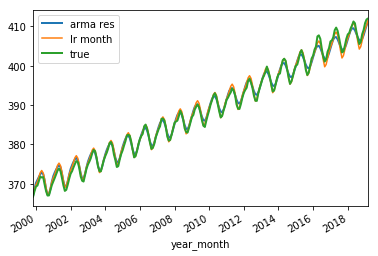

In [70]:
plt.plot(ppm.index[500:], pred_arma_res, label="arma res", linewidth=2)
plt.plot(ppm.index[500:], lr_poly_month_ohe.predict(X_test_month), label="lr month")

ppm[500:].plot(label="true", ax=plt.gca(), linewidth=2)
plt.legend(loc="best")


In [71]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ppm[500:], lr_poly_month_ohe.predict(X_test_month))

0.5357326216862447

In [72]:
mean_squared_error(ppm[500:], pred_arma_res)

0.7928569219569935

# FBProphet

In [73]:
fb_ppm = pd.DataFrame(ppm).reset_index()
fb_ppm.columns = ['ds', 'y']

In [74]:
fb_ppm.head()

,ds,y
0,1958-03-01,315.71
1,1958-04-01,317.45
2,1958-05-01,317.50
3,1958-06-01,317.10
4,1958-07-01,315.86


In [75]:
from fbprophet import Prophet
m = Prophet()
m.fit(fb_ppm[:500])

/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [76]:
forecast = m.predict(fb_ppm)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
728,2018-11-01,397.400741,370.824987,423.213376
729,2018-12-01,398.670367,371.610657,424.411238
730,2019-01-01,399.718570,372.399944,426.383393
731,2019-02-01,400.516141,372.962879,427.127663
732,2019-03-01,401.299530,373.992773,428.148541


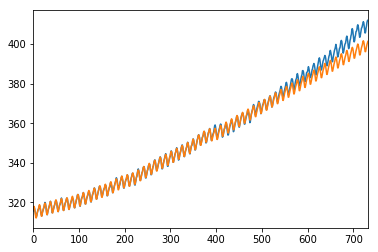

In [77]:
fb_ppm.y.plot()
forecast.yhat.plot()
plt.savefig("images/prophet_forecast.png")

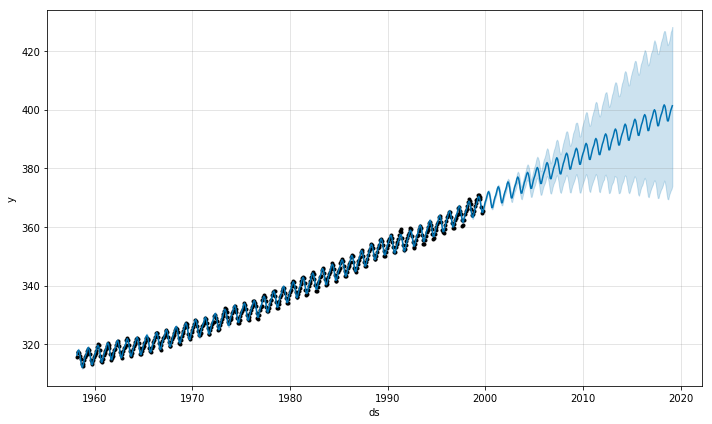

In [78]:
m.plot(forecast);
plt.savefig("images/prophet_forecast_uncertainty.png")

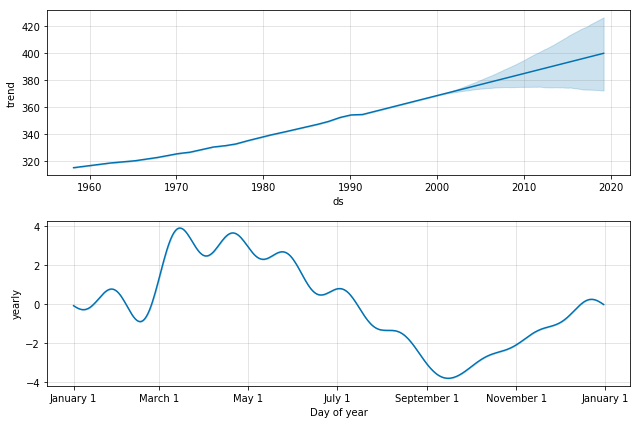

In [79]:
m.plot_components(forecast);
plt.savefig("images/prophet_forecast_components.png")

# Classification

In [80]:
from scipy.io import arff

In [81]:
data = arff.loadarff("../data/ElectricDevices_TRAIN.arff")[0]

FileNotFoundError: [Errno 2] No such file or directory: '../data/ElectricDevices_TRAIN.arff'

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.shape

In [ ]:
X_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1].astype(int)

In [ ]:
y_train.head()

In [ ]:
fig, axes = plt.subplots(5, 1)
for ax, label in zip(axes.ravel(), range(1, 6)):
    X_train.iloc[np.where(y_train==label)[0][:5]].T.plot(ax=ax, legend=False)